In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fdscheme as fds
import rbfinterpolate as rbf
from numerical_solvers_and_models import *
from sklearn.neighbors import NearestNeighbors
from tabulate import tabulate
from save import *

In [2]:
# --------------------------
# Global Variables
# --------------------------
rbf_shape = 'gaussian'
start_time = 0
stop_time = 1000
time_step = 0.001
init_cond = np.array([0, 1, 0])

# Abstract
In this work we attempt to calculate the Lyapunov exponents of five different attractors that exhibit chaotic behavior: Lorenz, Rossler, Chua, Signum, and Rabinovich-Fabrikant, using radial basis function scattered data interpolation. We try to optimize the shaping parameter $\epsilon$ using the "drop one" method (Rippa 1999) in order to obtain the most accurate results. We compare our results against another algorithm (Deici 1997) for calculating Lyapunov Exponents. All attractors are calculated on a time-scale of 0 to 1000 with a step size of h=0.01. The initial condition (x, y, z) = (0, 1, 0) is used for all the attractors except for Rabinovich-Fabrikant, which uses the initial condition (0.1, 0.1, 0.1)

# Lorenz Attractor
Just to get our feet wet and to build some more direct familiarity with Takens Embedding Theorem, we turn to one of the classics of dynamical systems, the Lorenz-63 equations, given by the system

\begin{align}
\dot{y}_{1} = & \sigma(y_{2}-y_{1})\\
\dot{y}_{2} = & ry_{1} - y_{2} - y_{1}y_{3}\\
\dot{y}_{3} = & -by_{3} + y_{1}y_{2}
\end{align}

Following the approach laid out in *Broomhead et al, Physica D, 217-236, 1986*, we use the parameter values

$$
\sigma = 16, \quad b = 4, \quad r = 40
$$

starting from an initial condition of ${\bf x} = (0,1,0)$.  A general solution for generic initial condition ${\bf x}$ can be described via the flow map ${\bf y}(t) = \varphi(t;{\bf x})$ which in coordinates is given by
$$
\varphi(t;{\bf x}) = (y_{1}(t;{\bf x}), y_{2}(t;{\bf x}), y_{3}(t;{\bf x})), \quad y_{j}(0;{\bf x}) = x_{j}, ~ j=1,2,3.
$$

We numerically solve this on the time interval $0\leq t \leq 90$ using a fourth order Runge-Kutta scheme with a time step of $\delta t=.01$.  As we expect, we get the now famous *Lorenz Butterfly* when we parametrically plot the solution paths against one another.  

In [127]:
# --------------------------
# Dynamical System Data
# --------------------------
sigma = 16
rval = 40
bval = 4
system = lambda t, X: fds.Systems(X).lorenz(16, 40, 4) #delete values contained in argument for canonical lorenz
solver = fds.Scheme(system, init_cond, start_time, stop_time, time_step)
rawdata, name = solver.runge_kutta()

In [36]:
fine = fds.Scheme(system, init_cond, start_time, stop_time, time_step/10)
finedata, name = fine.runge_kutta()

In [37]:
# # --------------------------
# # Attractor Plots
# # --------------------------
# """3D Plot"""
# print('Plotting 3D attractor...')
# save_attractor = create_directory('Plots')
# save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
# ax.plot3D(rawdata[0,:], rawdata[1,:], rawdata[2,:])
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_xlabel('z')
# ax.set_title(r'Lorenz Attractor for: $\sigma=16$, $R=40$, $b=4$') #change is system changes
# plot_name = 'Lorenz'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_3D, plot_name, '.png')
# filepath = save_attractor_3D + plot_name
# plt.savefig(filepath)
# plt.show()

# """2D Plots"""
# print('Plotting 2D projections of attractor...')
# save_attractor_2D = create_subdirectory(save_attractor, 'Attractor Plots', '2D Plots')
# plt.figure(figsize=(5,15))
# plt.suptitle(r'Lorenz Attractor for: $\sigma=10$, $R=28$, $b=\frac{8}{3}$')
# plt.subplot(3,1,1)
# plt.plot(rawdata[0, :], rawdata[1, :])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('XY Plot')

# plt.subplot(3,1,2)
# plt.plot(rawdata[0, :], rawdata[2, :])
# plt.xlabel('x')
# plt.ylabel('z')
# plt.title('XZ Plot')

# plt.subplot(3,1,3)
# plt.plot(rawdata[1, :], rawdata[2, :])
# plt.xlabel('y')
# plt.ylabel('z')
# plt.title('XZ Plot')
# plot_name = 'Lorenz'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_2D, plot_name, '.png')
# filepath = save_attractor_2D + plot_name
# plt.savefig(filepath)
# plt.show()

## Lyupanov Exponents using the Model Equations
For a given solution, we can compute the affiliated Jacobian of the Lorenz equations, thereby generating the affiliated time-dependent linear system 

$$
\frac{d{\bf U}}{dt} = J(t){\bf U}, ~ {\bf U}(0) = {\bf I},
$$

where

$$
J(t) = \begin{pmatrix}
-\sigma & \sigma & 0 \\ r-y_{3}(t) & -1 & -y_{1}(t) \\ y_{2}(t) & y_{1}(t) & -b
\end{pmatrix}
$$

Using a discretized approximation to the solution of the original Lorenz system defined at discrete times $\left\{t_{j}\right\}_{j=0}^{N_{T}}$ where $t_{0}=0$ and $t_{j} = j\delta t$, to generate an approximation to the Lyupanov exponents, we solve for $t_{j}\leq t \leq t_{j+1}$: 
$$
\frac{d}{dt}{\bf U}_{j} = J(t){\bf U}_{j}, ~ {\bf U}_{j}(t_{j}) = {\bf Q}_{j}
$$
where ${\bf Q}_{0}={\bf I}$ and we perform a QR-decomposition such that 
$$
{\bf U}_{j}(t_{j+1}) = {\bf Q}_{j+1}{\bf R}_{j+1}
$$
Then the $m^{th}$ Lyupanov exponent $\lambda_{m}$ is found from the formula 
$$
\lambda_{m} = \lim_{j\rightarrow \infty}\frac{1}{t_{j}}\sum_{k=1}^{j}\log  \left|({\bf R}_{k})_{mm} \right|
$$
For further details on the theory here, see **Dieci et al, On the Computation of Lyapunov Exponents for Continuous Dynamical Systems, SIAM J. Num. Analysis, 34, 402-423, 1997**.

In [128]:
lyu_vals = lorenz_lyupanov_solver(rawdata, sigma, rval, bval, time_step)
print(lyu_vals)

[ 1.36267637e+00  3.62334599e-03 -2.23662786e+01]


In [39]:
# # -------------------
# # Save Dialog
# # -------------------
# head = ['Attractor', 'lambda 1', 'lambda 2', 'lambda 3']
# row = ['Lorenz', lyu_vals[0], lyu_vals[1], lyu_vals[2]]
# table = tabulate([head, row], headers='firstrow')
# save_table = create_directory('Tables')
# table_name = 'Deici Lyapunov exponents'
# plot_name = name_checker(save_table, table_name, '.txt')
# table_name = save_table + 'Deici Lyapunov exponents'
# table_write = open(table_name + '.txt', 'w')
# table_write.write(table)
# table_write.close()
# print('Comparison Lyapunov Exponents: \n', table)

For the values used in Deici, we get comparable approximations to those listed in their tables for the Lorenz63 equations.  Thus we have a believable baseline now.  

Now to get estimates of Lyupanov exponents from just data alone, we need estimates of Jacobians of maps we otherwise do not have access to.  In Abarbanel et al, this is dealt with via least-squares fitting to Taylor series expansions.  Aside from being algorithmically unweildy, I also wonder how accurate that really is in the long run.  

Thus, I propose instead to use Radial Basis Functions (RBFs) to do scattered interpolation to generate analytic approximations to the map at each time step using nearest-neighbors to a given point ${\bf y}(t_{j})$.  This should produce a sequence of approximate Jacobians, say $\tilde{{\bf J}}_{j}$.  From time step to time step, we have the analytic formula for the matrices ${\bf U}_{j}$

$$
{\bf U}_{j}(t_{j+1}) = {\bf Q}_{j} + \int_{t_{j}}^{t_{j+1}}{\bf J}(t){\bf U}_{j}(t)dt
$$

To get a stable approximation scheme, we can use a Trapezoid approximation to the integral so that

$$
\left({\bf I} - \frac{\delta t}{2} {\bf J}_{j+1} \right){\bf U}_{j}(t_{j+1}) = \left({\bf I} + \frac{\delta t}{2} {\bf J}_{j} \right){\bf Q}_{j}.
$$

In [129]:
# --------------------------
# Data Manipulation
# --------------------------
transient_skp = 400
reddata = rawdata[:, transient_skp:]
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

So to test, we cut off the first 400 timesteps to avoid transients, and then we generate a list of the 100 nearest neighbors to every point on the trajectory.  We then compare the numerically approximated Jacobian to the actual one.  Turns out, not half bad using Gaussian RBFs with a shape parameter set to $\epsilon = 10$.  Could do better possibly, but we'll have to explore that issue.  

In [ ]:
# --------------------------
# Finding Optimal Shape Param
# --------------------------
epvals = np.linspace(0.1, 1000, 1001)
ptindx = 10
fine_ind = 10*ptindx
yloc = reddata[:, ptindx]
nnindices = indices[ptindx]
ipts = reddata[:, nnindices]
interpolator = rbf.RBF_Interpolate(rbf_shape, ipts, time_step)
optimal_shape_parameter = rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).shape_parameter_tuner()

In [42]:
# # -----------------------
# # Save dialog
# # -----------------------
# row = [rbf_shape, optimal_shape_parameter]
# table = tabulate([row])
# save_table = create_directory('Tables')
# save_table = create_subdirectory(save_table, 'Lorenz')
# table_name = 'Optimal Epsilon Lorenz'
# plot_name = name_checker(save_table, table_name, '.txt')
# filepath = save_table + table_name + '.txt'
# table_write = open(filepath, 'a')
# table_write.write(table)
# table_write.close()
# print(table)

In [43]:
# -----------------------
# Fill distance
# -----------------------
window = 4
hfill = interpolator.fill_distance_compute(finedata[:,fine_ind-window:fine_ind+window].T)
print(hfill)

48.88601563345352


In [44]:
def fill_distance_compute(ipts, mpts):
    nivls = np.shape(ipts)[0]
    nmvls = np.shape(mpts)[0]

    ixcoords = np.zeros((nivls, 1), dtype=np.float64)
    iycoords = np.zeros((nivls, 1), dtype=np.float64)
    izcoords = np.zeros((nivls, 1), dtype=np.float64)
    ixcoords[:, 0] = ipts[:, 0]
    iycoords[:, 0] = ipts[:, 1]
    izcoords[:, 0] = ipts[:, 2]

    mxcoords = np.zeros((nmvls, 1), dtype=np.float64)
    mycoords = np.zeros((nmvls, 1), dtype=np.float64)
    mzcoords = np.zeros((nmvls, 1), dtype=np.float64)
    mxcoords[:, 0] = mpts[:, 0]
    mycoords[:, 0] = mpts[:, 1]
    mzcoords[:, 0] = mpts[:, 2]

    difx = np.tile(mxcoords.T, (nivls, 1)) - np.tile(ixcoords, (1, nmvls))
    dify = np.tile(mycoords.T, (nivls, 1)) - np.tile(iycoords, (1, nmvls))
    difz = np.tile(mzcoords.T, (nivls, 1)) - np.tile(izcoords, (1, nmvls))
    dist = np.sqrt(difx ** 2. + dify ** 2. + difz ** 2.)
    return np.amax(np.amin(dist, axis=0))

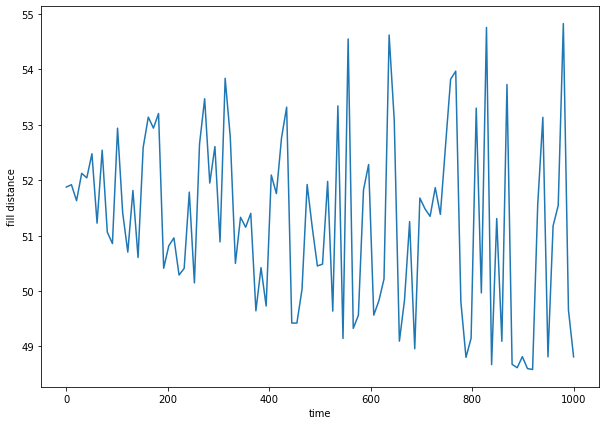

In [45]:
x = np.linspace(0,1000,100)
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Fill Distance')
fill_list = np.zeros(x.size)
for i in range (0,100):
    fill_list[i]=fill_distance_compute(np.reshape(ipts[:,i], (1,3)), finedata[:,fine_ind-window:fine_ind+window].T)
plt.figure(figsize=(10,7))
plt.plot(x, fill_list)
plt.xlabel(r'time')
plt.ylabel(r'fill distance')
plot_name = 'Lorenz005 Fill Distance'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [23]:
x

array([   0.        ,   10.1010101 ,   20.2020202 ,   30.3030303 ,
         40.4040404 ,   50.50505051,   60.60606061,   70.70707071,
         80.80808081,   90.90909091,  101.01010101,  111.11111111,
        121.21212121,  131.31313131,  141.41414141,  151.51515152,
        161.61616162,  171.71717172,  181.81818182,  191.91919192,
        202.02020202,  212.12121212,  222.22222222,  232.32323232,
        242.42424242,  252.52525253,  262.62626263,  272.72727273,
        282.82828283,  292.92929293,  303.03030303,  313.13131313,
        323.23232323,  333.33333333,  343.43434343,  353.53535354,
        363.63636364,  373.73737374,  383.83838384,  393.93939394,
        404.04040404,  414.14141414,  424.24242424,  434.34343434,
        444.44444444,  454.54545455,  464.64646465,  474.74747475,
        484.84848485,  494.94949495,  505.05050505,  515.15151515,
        525.25252525,  535.35353535,  545.45454545,  555.55555556,
        565.65656566,  575.75757576,  585.85858586,  595.95959

In [90]:
# -----------------------
# Save dialog
# -----------------------
row = ['lorenz', hfill]
table = tabulate([row])
save_table = create_directory('Tables')
#save_table = create_subdirectory(save_table, 'Lorenz')
table_name = 'Fill Distance'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

------  -------
lorenz  21.9154
------  -------


In [131]:
# ------------------------
# Jacobian Comparison
# ------------------------
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[0, 0] = -sigma
pjac_mat_exact[0, 1] = sigma
pjac_mat_exact[1, 1] = -1.
pjac_mat_exact[2, 2] = -bval
NTT = np.shape(reddata)[1]
for jj in range(10,11):
    
    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    
    pjac_mat_exact[1, 0] = rval-yloc[2]
    pjac_mat_exact[1, 2] = -yloc[0]
    pjac_mat_exact[2, 0] = yloc[1]
    pjac_mat_exact[2, 1] = yloc[0]
    
    jacmat, cval = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)

    print('Estimated Jacobian:')
    print(jacmat,'\n')
    print('Actual Jacobian')
    print(pjac_mat_exact)
    print("Condition number is: %1.2e" % cval)

Estimated Jacobian:
[[ -106775.667708     154797.25707823   151447.27516421]
 [ -489802.00968453   710090.00542012   694730.56251411]
 [  811053.47796529 -1175826.55480552 -1150393.06008773]] 

Actual Jacobian
[[-16.          16.           0.        ]
 [ -5.24013376  -1.           2.4405307 ]
 [-13.25804875  -2.4405307   -4.        ]]
Condition number is: 2.82e+18


In [415]:
# # -------------------
# # Save dialog
# # -------------------
# save_jacmat = create_directory('Jacobian')
# save_jacmat = create_subdirectory(save_jacmat, 'Lorenz')
# name = 'Lorenz Estimated Jacobian' + rbf_shape
# plot_name = name_checker(save_jacmat, name, '.txt')
# filepath = save_jacmat + name + '.txt'
# table_write = open(filepath, 'w')
# table_write.write(str(jacmat))
# table_write.close()

# name = 'Lorenz Exact Jacobian'
# plot_name = name_checker(save_jacmat, name, '.txt')
# filepath = save_jacmat + name + '.txt'
# table_write = open(filepath, 'w')
# table_write.write(str(pjac_mat_exact))
# table_write.close()

Having established that the numerically approximated Jacobians are reasonably accurate, we now go ahead and compute the affiliated Lyupanov exponents.  

Calculating condition numbers...


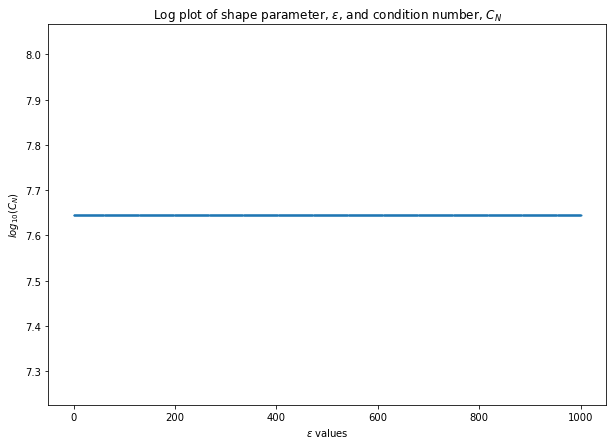

In [416]:
# # -------------------------
# # Condition Number Plot
# # -------------------------
# print('Calculating condition numbers...')
# save_plot = create_directory('Plots')
# save_plot = create_subdirectory(save_plot, 'Condition Number Plots')
# condnumbers = [rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).condition_number_compute(epval) for epval in epvals]
# plt.figure(figsize=(10,7))
# plt.scatter(epvals, np.ma.log10(condnumbers), s=1)
# plt.xlabel(r'$\epsilon$ values')
# plt.ylabel(r'$log_{10}(C_N)$')
# plt.title(r'Log plot of shape parameter, $\epsilon$, and condition number, $C_N$')
# plot_name = 'Lorenz' + rbf_shape
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_plot, plot_name, '.png')
# filepath = save_plot + plot_name
# plt.savefig(filepath)
# plt.show()

In [132]:
# ---------------------------
# Calculating Lyapunov Exp
# ---------------------------
NTT = np.shape(reddata)[1]
qprior = np.eye(3, dtype=np.float64)
imat = np.eye(3, dtype=np.float64)
rvals = np.ones((3, NTT), dtype=np.float64)
for jj in range(NTT - 1):
    jacmatn, cvaln = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    jacmatp, cvalp = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj + 1, NTT)
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat - time_step / 2 * jacmatp), (imat + time_step / 2 * jacmatn) @ qprior))
    rvals[:, jj] = np.diag(rnext)
lvals = np.sum(np.log(np.abs(rvals)), 1) / stop_time
print('Estimated Lyapunov Exponents: ', lvals)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Estimated Lyapunov Exponents:  [ 0.1018164  -0.06394542 -2.11903795]
Comparison Lyapunov Exponents:  [ 1.36267637e+00  3.62334599e-03 -2.23662786e+01]


In [141]:
# --------------------
# Save dialog
# --------------------
head = ['RBF', 'lambda 1', 'lambda 2', 'lambda 3']
row = [rbf_shape, lvals[0], lvals[1], lvals[2]]
table = tabulate([head, row], headers='firstrow')
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Lorenz')
table_name = 'RBF Estimated Lorenz 001 Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

RBF         lambda 1    lambda 2    lambda 3
--------  ----------  ----------  ----------
gaussian    0.101816  -0.0639454    -2.11904


# Remarks
We can see that the Lorenz system is well behaved and serves as a standard for the other attractors regarding the RBF 'drop one' scheme. I is worth noting that for the canonical lorenz: $\sigma=10$, $r=28$, and $b=\frac{8}{3}$, the exponents estimated from the scattered data interpolation are very much in line with what is found in the literature **Meador, Numerical Calculation of Lyapunov Exponents for Three-Dimensional Systems of Ordinary Differential Equations, Marshall University, 2011.**

# Rossler Attractor

The Rossler system is defined as:
\begin{align}
\dot{y}_{1} = & -y_{2}-y_{3}\\
\dot{y}_{2} = & y_{1} + ay_{2}\\
\dot{y}_{3} = & b + y_{3}(y_{1} - c)
\end{align}

The Jacobian for the Rossler system is:
$$
J(t) = \begin{pmatrix}
0 & -1 & -1 \\ 
1 & a & 0 \\ 
y_{3}(t) & 0 & y_{1}-c
\end{pmatrix}
$$

The values for the coefficients are: a = 0.2, b = 0.2, c = 5.7

In [11]:
def rossler_lyupanov_solver(yt, a, b, c, dt):
    NT = np.shape(yt)[1]
    gs_rem_terms = np.ones((3, NT), dtype=np.float64)
    jac_mat = np.zeros((3, 3), dtype=np.float64)
    jac_mat[0, 1] = -1.
    jac_mat[0, 2] = -1.
    jac_mat[1, 0] = 1.
    jac_mat[1, 1] = a
    
    #print(jac_mat)
    
    uprior = np.eye(3, dtype=np.float64)

    for jj in range(NT-1):
        jac_mat[2, 0] = yt[2, jj]
        jac_mat[2, 2] = yt[0, jj] - c
        
        #print(jac_mat)

        jupdate = lambda uvec: jac_mat @ uvec
        unext = np.zeros((3, 3), dtype=np.float64)

        for ll in range(3):
            unext[:, ll] = rk4(uprior[:, ll], jupdate, dt)

        uprior, rnext = np.linalg.qr(unext)
        gs_rem_terms[:, jj+1] = np.diag(rnext)
        

    return np.sum(np.log(np.abs(gs_rem_terms)), 1)/(NT*dt)

In [18]:
# --------------------------
# Dynamical System Data
# --------------------------
a = 0.2
b = 0.2
c = 5.7
start_time=0
stop_time=1000
time_step=0.05
#new_init=np.array([0,0,30])
system = lambda t, X: fds.Systems(X).rossler()
solver = fds.Scheme(system, init_cond, start_time, stop_time, time_step)
rawdata, name = solver.runge_kutta()

In [19]:
fine = fds.Scheme(system, init_cond, start_time, stop_time, time_step/10)
finedata, name = fine.runge_kutta()

In [180]:
init_cond

array([0, 1, 0])

Plotting 3D attractor...
A file of this name already exists! Do you want to rewrite it? [y/n]: n


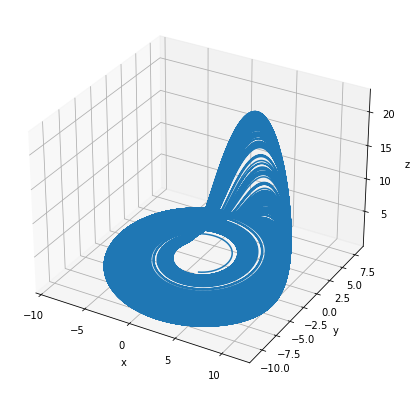

In [142]:
# --------------------------
# Attractor Plots
# --------------------------
print('Plotting 3D attractor...')
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.plot3D(reddata[0, :], reddata[1, :], reddata[2, :])
#ax.set_title(r'Rossler Attractor for $a=0.2$, $b=0.2$, $c=5.7$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plot_name = 'Rossler555'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
# plt.savefig(filepath)
plt.show()

# """2D Plots"""
# print('Plotting 2D projections of attractor...')
# save_attractor_2D = create_subdirectory(save_attractor, 'Attractor Plots', '2D Plots')
# plt.figure(figsize=(5,15))
# plt.suptitle(r'Rossler Attractor for $a=0.2$, $b=0.2$, $c=5.7$')
# plt.subplot(3,1,1)
# plt.plot(rawdata[0, :], rawdata[1, :])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('XY Plot')

# plt.subplot(3,1,2)
# plt.plot(rawdata[0, :], rawdata[2, :])
# plt.xlabel('x')
# plt.ylabel('z')
# plt.title('XZ Plot')

# plt.subplot(3,1,3)
# plt.plot(rawdata[1, :], rawdata[2, :])
# plt.xlabel('y')
# plt.ylabel('z')
# plt.title('XZ Plot')
# plot_name = 'Rossler'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_2D, plot_name, '.png')
# filepath = save_attractor_2D + plot_name
# plt.savefig(filepath)
# plt.show()

We use the algorithm from (Deici 1997) to generate results to compare against

In [20]:
lyu_vals = rossler_lyupanov_solver(rawdata, a, b, c, time_step)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Comparison Lyapunov Exponents:  [ 7.62973133e-02  3.30676458e-03 -5.40539477e+00]


In [21]:
# -------------------
# Save Dialog
# -------------------
row = ['Rossler005', lyu_vals[0], lyu_vals[1], lyu_vals[2]]
table = tabulate([row])
save_table = create_directory('Tables')
table_name = 'Deici Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write('\n' + table)
table_write.close()
print('Comparison Lyapunov Exponents: \n', table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
Comparison Lyapunov Exponents: 
 ----------  ---------  ----------  --------
Rossler005  0.0762973  0.00330676  -5.40539
----------  ---------  ----------  --------


These Lyapunov exponents reflect the findings in **Meador, Numerical Calculation of Lyapunov Exponents for
Three-Dimensional Systems of Ordinary
Differential Equations, Marshall University, 2011**. Which provides a second sanity check. Meador cites **Sprott, J. C. Chaos and Time-Series Analysis. Oxford University Press, 2003.** as comparison for their values

In [22]:
# --------------------------
# Data Manipulation
# --------------------------
transient_skp = int(10/time_step)
reddata = rawdata[:, transient_skp:]
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

Plotting epsilons...
Save file as: Rossler005


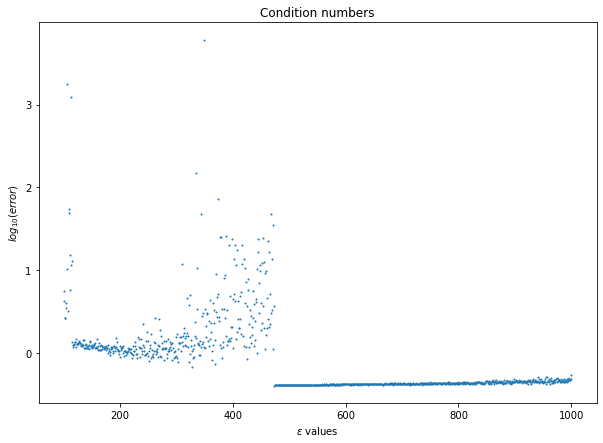

In [23]:
# --------------------------
# Finding Optimal Shape Param
# --------------------------
epvals = np.linspace(0.1, 1000, 1001)
ptindx = 10
fine_ind = 10*ptindx
yloc = reddata[:, ptindx]
nnindices = indices[ptindx]
ipts = reddata[:, nnindices]
interpolator = rbf.RBF_Interpolate(rbf_shape, ipts, time_step)
optimal_shape_parameter = rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).shape_parameter_tuner()

In [24]:
# -----------------------
# Save dialog
# -----------------------
row = [rbf_shape, optimal_shape_parameter]
table = tabulate([row])
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Rossler')
table_name = 'Optimal Epsilon Rossler5530'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
--------  -----
gaussian  473.5
--------  -----


In [25]:
# -----------------------
# Fill distance
# -----------------------
window = 4
hfill = interpolator.fill_distance_compute(finedata[:,fine_ind-window:fine_ind+window].T)
print(hfill)

1.0854765125123211


In [26]:
# -----------------------
# Save dialog
# -----------------------
row = ['rossler005', hfill]
table = tabulate([row])
save_table = create_directory('Tables')
#save_table = create_subdirectory(save_table, 'Rossler')
table_name = 'Fill Distance'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
----------  -------
rossler005  1.08548
----------  -------


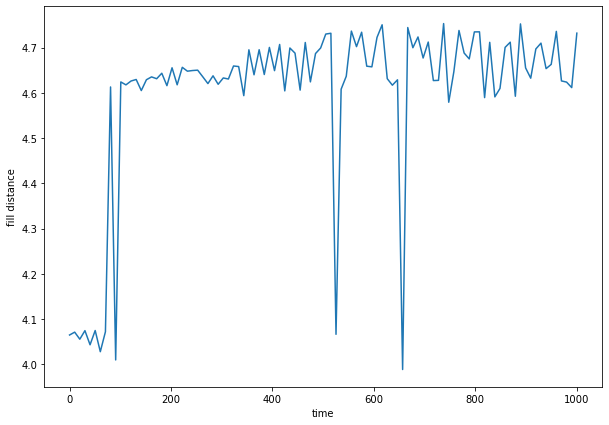

In [28]:
x = np.linspace(0,1000,100)
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Fill Distance')
fill_list = np.zeros(x.size)
for i in range (0,100):
    fill_list[i]=fill_distance_compute(np.reshape(ipts[:,i], (1,3)), finedata[:,fine_ind-window:fine_ind+window].T)
plt.figure(figsize=(10,7))
plt.plot(x, fill_list)
plt.xlabel(r'time')
plt.ylabel(r'fill distance')
plot_name = 'Rossler005 Fill Distance'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [29]:
# ------------------------
# Jacobian Comparison
# ------------------------
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[0, 1] = -1.
pjac_mat_exact[0, 2] = -1.
pjac_mat_exact[1, 0] = 1.
pjac_mat_exact[1, 1] = a
NTT = np.shape(reddata)[1]
for jj in range(10,11):
    
    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    
    pjac_mat_exact[2, 0] = yloc[2]
    pjac_mat_exact[2, 2] = yloc[0]-c
    
    jacmat, cval = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    print('Estimated Jacobian:')
    print(jacmat,'\n')
    print('Actual Jacobian')
    print(pjac_mat_exact)
    print("Condition number is: %1.2e" % cval)

Estimated Jacobian:
[[-1.53879737e-04 -9.99601723e-01 -9.94432786e-01]
 [ 9.99524289e-01  1.99825908e-01  5.60696822e-03]
 [-1.39844963e-02 -1.38734432e-02  2.20677482e+00]] 

Actual Jacobian
[[ 0.         -1.         -1.        ]
 [ 1.          0.2         0.        ]
 [ 0.05365054  0.         -3.22970492]]
Condition number is: 9.13e+18


In [160]:
jacmat

array([[ 4.95770853e-04, -9.99468173e-01, -1.04637020e+00],
       [ 9.99593699e-01,  1.99840743e-01, -5.88335677e-05],
       [ 2.53769497e-02, -1.70566295e-02, -3.17896154e+00]])

In [30]:
# -------------------
# Save dialog
# -------------------
save_jacmat = create_directory('Jacobian')
save_jacmat = create_subdirectory(save_jacmat, 'Rossler')
name = 'Rossler005 Estimated Jacobian' + rbf_shape
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(jacmat))
table_write.close()

name = 'Rossler005 Exact Jacobian'
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(pjac_mat_exact))
table_write.close()

We can see that the actual and estimated Jacobians are very different!

Calculating condition numbers...


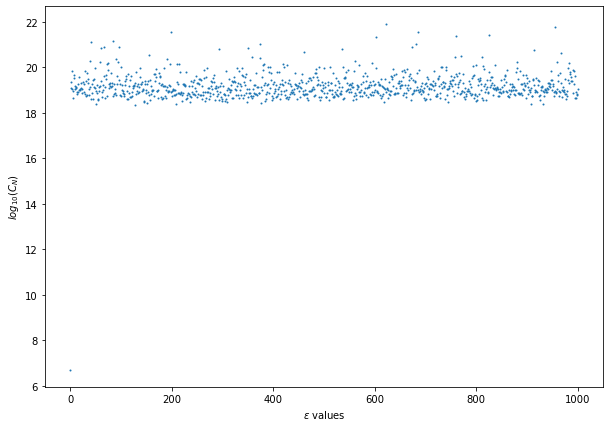

In [31]:
# -------------------------
# Condition Number Plot
# -------------------------
print('Calculating condition numbers...')
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Condition Number Plots')
condnumbers = [rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).condition_number_compute(epval) for epval in epvals]
plt.figure(figsize=(10,7))
plt.scatter(epvals, np.ma.log10(condnumbers), s=1)
plt.xlabel(r'$\epsilon$ values')
plt.ylabel(r'$log_{10}(C_N)$')
#plt.title(r'Log plot of shape parameter, $\epsilon$, and condition number, $C_N$')
plot_name = 'Rossler005 ' + rbf_shape
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [32]:
# ---------------------------
# Calculating Lyapunov Exp
# ---------------------------
NTT = np.shape(reddata)[1]
qprior = np.eye(3, dtype=np.float64)
imat = np.eye(3, dtype=np.float64)
rvals = np.ones((3, NTT), dtype=np.float64)
for jj in range(NTT - 1):
    jacmatn, cvaln = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    jacmatp, cvalp = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj + 1, NTT)
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat - time_step / 2 * jacmatp), (imat + time_step / 2 * jacmatn) @ qprior))
    rvals[:, jj] = np.diag(rnext)
lvals = np.sum(np.log(np.abs(rvals)), 1) / stop_time
print('Estimated Lyapunov Exponents: ', lvals)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Estimated Lyapunov Exponents:  [ 0.1188389   0.00616554 -1.25222116]
Comparison Lyapunov Exponents:  [ 7.62973133e-02  3.30676458e-03 -5.40539477e+00]


In [33]:
# --------------------
# Save dialog
# --------------------
head = ['RBF', 'lambda 1', 'lambda 2', 'lambda 3']
row = [rbf_shape, lvals[0], lvals[1], lvals[2]]
table = tabulate([head, row], headers='firstrow')
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Rossler')
table_name = 'RBF Estimated Rossler005 Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

RBF         lambda 1    lambda 2    lambda 3
--------  ----------  ----------  ----------
gaussian    0.118839  0.00616554    -1.25222


# Remarks
Rossler is poorly behaved. It is interesting that the maximal Lyapunov exponent as well as the middle exponent are close to what we observe in comparison. However, the smallest Lyapunov exponent is very different

# Chua Attractor

The Chua system is defined as:
\begin{align}
\dot{y}_{1} = & a(y_{2} - y_{1} - f(y_{1}))\\
\dot{y}_{2} = & y_{1} - y_{2} + y_{3}\\
\dot{y}_{3} = & -by_{2}
\end{align}

where the function $f(y_{1})$ is defined as:
$$
f(y_{1}) = \begin{cases}
dy_{1} + c - d\ \ \ \text{for}\ \ \ x\geq 1 \\
cy_{1}\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{for}\ \ \ -1<x<1\\
dy_{1} - c + d\ \ \ \text{for}\ \ \ x\leq -1
\end{cases}
$$

The associated Jacobian is:
$$
J(t) = \begin{pmatrix}
-a(1 + f'(y_{1}(t))) & a & 0 \\ 
1 & -1 & 1 \\ 
0 & -b & 0
\end{pmatrix}
$$

where $f'(y_{1})$ is given by:
$$
f'(y_{1})=\begin{cases}
d \ \ \ \text{for}\ \ \ |y_{1}|\geq 1 \\
c \ \ \ \text{otherwise}
\end{cases}
$$

The values for the coefficients are: $a = 9$, $b = \frac{100}{7}$, $c = -\frac{8}{7}$, $d = -\frac{5}{7}$

In [200]:
def deriv_func(x, a=-8/7, b=-5/7):
    if np.abs(x)>=1:
        return b
    else:
        return a

def chua_lyupanov_solver(yt, a, b, dt):
    NT = np.shape(yt)[1]
    gs_rem_terms = np.ones((3, NT), dtype=np.float64)
    jac_mat = np.zeros((3, 3), dtype=np.float64)
    jac_mat[0, 1] = a
    jac_mat[1, 0] = 1.
    jac_mat[1, 1] = -1.
    jac_mat[1, 2] = 1
    jac_mat[2, 1] = -b
    
    #print(jac_mat)
    
    uprior = np.eye(3, dtype=np.float64)

    for jj in range(NT-1):
        jac_mat[0, 0] = -a*(1 + deriv_func(yt[0, jj]))
        
        #print(jac_mat)

        jupdate = lambda uvec: jac_mat @ uvec
        unext = np.zeros((3, 3), dtype=np.float64)

        for ll in range(3):
            unext[:, ll] = rk4(uprior[:, ll], jupdate, dt)

        uprior, rnext = np.linalg.qr(unext)
        gs_rem_terms[:, jj+1] = np.diag(rnext)
        

    return np.sum(np.log(np.abs(gs_rem_terms)), 1)/(NT*dt)

In [221]:
# --------------------------
# Dynamical System Data
# --------------------------
a = 9
b = 100/7
system = lambda t, X: fds.Systems(X).chua()
solver = fds.Scheme(system, init_cond, start_time, stop_time, time_step)
rawdata, name = solver.runge_kutta()

In [222]:
fine = fds.Scheme(system, init_cond, start_time, stop_time, time_step/10)
finedata, name = fine.runge_kutta()

In [223]:
# # --------------------------
# # Attractor Plots
# # --------------------------
# print('Plotting 3D attractor...')
# save_attractor = create_directory('Plots')
# save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
# fig = plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")
# ax.plot3D(rawdata[0, :], rawdata[1, :], rawdata[2, :])
# ax.set_title(r'Chua Attractor for $a=9$, $b=\frac{100}{7}$, $c=-\frac{8}{7}$, $d=-\frac{5}{7}$')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plot_name = 'Chua111'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_3D, plot_name, '.png')
# filepath = save_attractor_3D + plot_name
# plt.savefig(filepath)
# plt.show()

# """2D Plots"""
# print('Plotting 2D projections of attractor...')
# save_attractor_2D = create_subdirectory(save_attractor, 'Attractor Plots', '2D Plots')
# plt.figure(figsize=(5,15))
# plt.suptitle(r'Chua Attractor for $a=9$, $b=\frac{100}{7}$, $c=-\frac{8}{7}$, $d=-\frac{5}{7}$')
# plt.subplot(3,1,1)
# plt.plot(rawdata[0, :], rawdata[1, :])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('XY Plot')

# plt.subplot(3,1,2)
# plt.plot(rawdata[0, :], rawdata[2, :])
# plt.xlabel('x')
# plt.ylabel('z')
# plt.title('XZ Plot')

# plt.subplot(3,1,3)
# plt.plot(rawdata[1, :], rawdata[2, :])
# plt.xlabel('y')
# plt.ylabel('z')
# plt.title('XZ Plot')
# plot_name = 'Chua'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_2D, plot_name, '.png')
# filepath = save_attractor_2D + plot_name
# plt.savefig(filepath)
# plt.show()

In [204]:
# lyu_vals = chua_lyupanov_solver(rawdata, a, b, time_step)
# print('Comparison Lyapunov Exponents: ', lyu_vals)

Comparison Lyapunov Exponents:  [ 0.31638452  0.00317601 -2.50285865]


In [40]:
# # -------------------
# # Save Dialog
# # -------------------
# row = ['Chua', lyu_vals[0], lyu_vals[1], lyu_vals[2]]
# table = tabulate([row])
# save_table = create_directory('Tables')
# table_name = 'Deici Lyapunov exponents'
# plot_name = name_checker(save_table, table_name, '.txt')
# table_name = save_table + table_name + '.txt'
# table_write = open(table_name, 'a')
# table_write.write('\n' + table)
# table_write.close()
# print('Comparison Lyapunov Exponents: \n', table)

These Lyapunov exponents reflect the findings in **Meador, Numerical Calculation of Lyapunov Exponents for Three-Dimensional Systems of Ordinary Differential Equations, Marshall University, 2011.** Which provides a second sanity check. Meador cites **Sprott, J. C. Chaos and Time-Series Analysis. Oxford University Press, 2003. as comparison for their values**

In [224]:
# --------------------------
# Data Manipulation
# --------------------------
transient_skp = 400
reddata = rawdata[:, transient_skp:]
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

Plotting epsilons...
Save file as: 


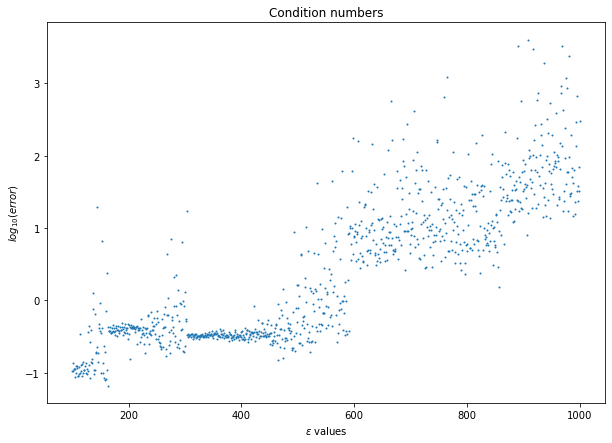

In [225]:
# --------------------------
# Finding Optimal Shape Param
# --------------------------
epvals = np.linspace(0.1, 1000, 1001)
ptindx = 10
fine_ind = 10*ptindx
yloc = reddata[:, ptindx]
nnindices = indices[ptindx]
ipts = reddata[:, nnindices]
interpolator = rbf.RBF_Interpolate(rbf_shape, ipts, time_step)
optimal_shape_parameter = rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).shape_parameter_tuner()

In [207]:
# # -----------------------
# # Save dialog
# # -----------------------
# row = [rbf_shape, optimal_shape_parameter]
# table = tabulate([row])
# save_table = create_directory('Tables')
# save_table = create_subdirectory(save_table, 'Chua')
# table_name = 'Optimal Epsilon Chua'
# plot_name = name_checker(save_table, table_name, '.txt')
# filepath = save_table + table_name + '.txt'
# table_write = open(filepath, 'a')
# table_write.write(table)
# table_write.close()
# print(table)

In [208]:
# # -----------------------
# # Fill distance
# # -----------------------
# window = 4
# hfill = interpolator.fill_distance_compute(finedata[:,fine_ind-window:fine_ind+window].T)
# print(hfill)

0.5803762911520683


In [209]:
# # -----------------------
# # Save dialog
# # -----------------------
# row = ['chua111', hfill]
# table = tabulate([row])
# save_table = create_directory('Tables')
# #save_table = create_subdirectory(save_table, 'Lorenz')
# table_name = 'Fill Distance'
# plot_name = name_checker(save_table, table_name, '.txt')
# filepath = save_table + table_name + '.txt'
# table_write = open(filepath, 'a')
# table_write.write(table)
# table_write.close()
# print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
-------  --------
chua111  0.580376
-------  --------


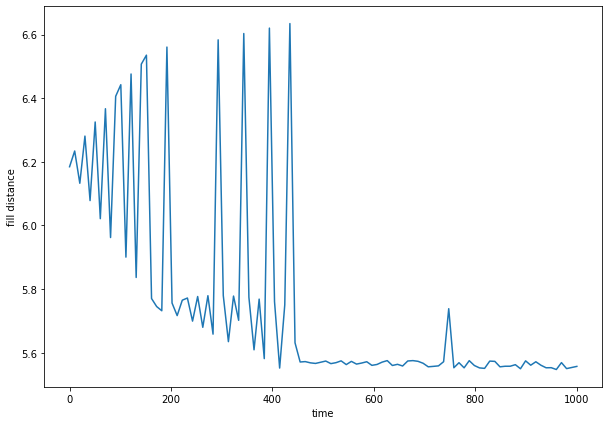

In [226]:
x = np.linspace(0,1000,100)
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Fill Distance')
fill_list = np.zeros(x.size)
for i in range (0,100):
    fill_list[i]=fill_distance_compute(np.reshape(ipts[:,i], (1,3)), finedata[:,fine_ind-window:fine_ind+window].T)
plt.figure(figsize=(10,7))
plt.plot(x, fill_list)
plt.xlabel(r'time')
plt.ylabel(r'fill distance')
plot_name = 'Chua Fill Distance'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [214]:
# ------------------------
# Jacobian Comparison
# ------------------------
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[0, 1] = a
pjac_mat_exact[1, 0] = 1.
pjac_mat_exact[1, 1] = -1.
pjac_mat_exact[1, 2] = 1
pjac_mat_exact[2, 1] = -b
NTT = np.shape(reddata)[1]
for jj in range(10,11):
    
    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    
    pjac_mat_exact[0, 0] = -a*(1 + deriv_func(yloc[0]))
    
    jacmat, cval = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    print('Estimated Jacobian:')
    print(jacmat,'\n')
    print('Actual Jacobian')
    print(pjac_mat_exact)
    print("Condition number is: %1.2e" % cval)

Estimated Jacobian:
[[-7.34932638e+00  1.66666147e+01 -1.90111958e+00]
 [ 1.02458919e+00 -1.03432377e+00  1.00991654e+00]
 [ 9.82133860e-04 -1.42850354e+01  2.92626608e-04]] 

Actual Jacobian
[[ -2.57142857   9.           0.        ]
 [  1.          -1.           1.        ]
 [  0.         -14.28571429   0.        ]]
Condition number is: 2.22e+18


In [215]:
# -------------------
# Save dialog
# -------------------
save_jacmat = create_directory('Jacobian')
save_jacmat = create_subdirectory(save_jacmat, 'Chua')
name = 'Chua111 Estimated Jacobian' + rbf_shape
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(jacmat))
table_write.close()

name = 'Chua111 Exact Jacobian'
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(pjac_mat_exact))
table_write.close()

We can see that the Jacobians are near each other for Chua! So we can expect good results

Calculating condition numbers...


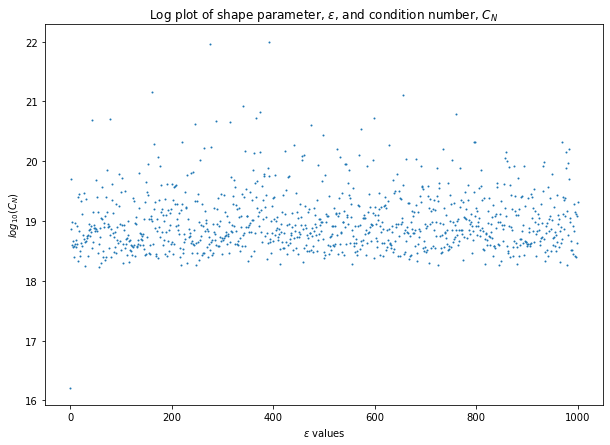

In [217]:
# -------------------------
# Condition Number Plot
# -------------------------
print('Calculating condition numbers...')
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Condition Number Plots')
condnumbers = [rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).condition_number_compute(epval) for epval in epvals]
plt.figure(figsize=(10,7))
plt.scatter(epvals, np.ma.log10(condnumbers), s=1)
plt.xlabel(r'$\epsilon$ values')
plt.ylabel(r'$log_{10}(C_N)$')
plt.title(r'Log plot of shape parameter, $\epsilon$, and condition number, $C_N$')
plot_name = 'Chua111' + rbf_shape
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [218]:
# ---------------------------
# Calculating Lyapunov Exp
# ---------------------------
NTT = np.shape(reddata)[1]
qprior = np.eye(3, dtype=np.float64)
imat = np.eye(3, dtype=np.float64)
rvals = np.ones((3, NTT), dtype=np.float64)
for jj in range(NTT - 1):
    jacmatn, cvaln = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    jacmatp, cvalp = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj + 1, NTT)
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat - time_step / 2 * jacmatp), (imat + time_step / 2 * jacmatn) @ qprior))
    rvals[:, jj] = np.diag(rnext)
lvals = np.sum(np.log(np.abs(rvals)), 1) / stop_time
print('Estimated Lyapunov Exponents: ', lvals)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Estimated Lyapunov Exponents:  [ 0.48236096 -0.04904427 -2.41641964]
Comparison Lyapunov Exponents:  [ 0.31638452  0.00317601 -2.50285865]


In [219]:
# --------------------
# Save dialog
# --------------------
head = ['RBF', 'lambda 1', 'lambda 2', 'lambda 3']
row = [rbf_shape, lvals[0], lvals[1], lvals[2]]
table = tabulate([head, row], headers='firstrow')
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Chua111')
table_name = 'RBF Estimated Chua Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

RBF             lambda 1    lambda 2    lambda 3
------------  ----------  ----------  ----------
multiquadric    0.482361  -0.0490443    -2.41642


# Remarks
The Chua attractor is well behaved and the RBF scheme provides good approximation

# Signum Attractor
The signum attractor is found in **Li, et. al, A unique signum switch for chaos and hyperchaos, PHYSCON, 2015**. This paper presents a 3D and 4D version of the attractor. For this analysis, we stick to the 3D model for now. The system is defined as:

\begin{align}
\dot{y}_{1} = & y_{2}-y_{1}\\
\dot{y}_{2} = & -y_{3}sgn(y_{1})\\
\dot{y}_{3} = & y_{1}sgn(y_{2}) - a
\end{align}

The Jacobian  is:
$$
J(t) = \begin{pmatrix}
1 & -1 & 0 \\ 
-2y_{3}\delta (y_{1}(t)) & 0 & -sgn(y_{1}(t)) \\ 
sgn(y_{2}(t)) & 2y_{1}\delta (y_{2}(t)) & 0
\end{pmatrix}
$$

The values for the coefficients are: a = 1

$\delta$ represents the dirac delta distribution

In [227]:
def dirac(x,sig=1):
   if -(1/(2*sig))<=x and x<=(1/(2*sig)):
       return 1
   else:
       return 0

def signum_lyupanov_solver(yt, a, dt):
    NT = np.shape(yt)[1]
    gs_rem_terms = np.ones((3, NT), dtype=np.float64)
    jac_mat = np.zeros((3, 3), dtype=np.float64)
    jac_mat[0, 0] = -1
    jac_mat[0, 1] = 1.
    
    #print(jac_mat)
    
    uprior = np.eye(3, dtype=np.float64)

    for jj in range(NT-1):
        jac_mat[1, 0] = -2*yt[2, jj]*dirac(yt[0, jj])
        jac_mat[1, 2] = -np.sign(yt[0, jj])
        jac_mat[2, 0] = np.sign(yt[1, jj])
        jac_mat[2, 1] = 2*yt[0, jj]*dirac(yt[1, jj])
        
        #print(jac_mat)

        jupdate = lambda uvec: jac_mat @ uvec
        unext = np.zeros((3, 3), dtype=np.float64)

        for ll in range(3):
            unext[:, ll] = rk4(uprior[:, ll], jupdate, dt)

        uprior, rnext = np.linalg.qr(unext)
        gs_rem_terms[:, jj+1] = np.diag(rnext)
        

    return np.sum(np.log(np.abs(gs_rem_terms)), 1)/(NT*dt)

In [228]:
# --------------------------
# Dynamical System Data
# --------------------------
a = 1
system = lambda t, X: fds.Systems(X).signum()
solver = fds.Scheme(system, init_cond, start_time, stop_time, time_step)
rawdata, name = solver.runge_kutta()

In [229]:
fine = fds.Scheme(system, init_cond, start_time, stop_time, time_step/10)
finedata, name = fine.runge_kutta()

In [230]:
# # --------------------------
# # Attractor Plots
# # --------------------------
# print('Plotting 3D attractor...')
# save_attractor = create_directory('Plots')
# save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
# fig = plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")
# ax.plot3D(rawdata[0, :], rawdata[1, :], rawdata[2, :])
# ax.set_title(r'Signum Attractor for $a=1$')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plot_name = 'Signum'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_3D, plot_name, '.png')
# filepath = save_attractor_3D + plot_name
# plt.savefig(filepath)
# plt.show()

# """2D Plots"""
# print('Plotting 2D projections of attractor...')
# save_attractor_2D = create_subdirectory(save_attractor, 'Attractor Plots', '2D Plots')
# plt.figure(figsize=(5,15))
# plt.suptitle(r'Signum Attractor for $a=1$')
# plt.subplot(3,1,1)
# plt.plot(rawdata[0, :], rawdata[1, :])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('XY Plot')

# plt.subplot(3,1,2)
# plt.plot(rawdata[0, :], rawdata[2, :])
# plt.xlabel('x')
# plt.ylabel('z')
# plt.title('XZ Plot')

# plt.subplot(3,1,3)
# plt.plot(rawdata[1, :], rawdata[2, :])
# plt.xlabel('y')
# plt.ylabel('z')
# plt.title('XZ Plot')
# plot_name = 'Signum'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_2D, plot_name, '.png')
# filepath = save_attractor_2D + plot_name
# plt.savefig(filepath)
# plt.show()

In [231]:
# lyu_vals = signum_lyupanov_solver(rawdata, a, time_step)
# print('Comparison Lyapunov Exponents: ', lyu_vals)

In [232]:
# # -------------------
# # Save Dialog
# # -------------------
# row = ['Signum', lyu_vals[0], lyu_vals[1], lyu_vals[2]]
# table = tabulate([row])
# save_table = create_directory('Tables')
# table_name = 'Deici Lyapunov exponents'
# plot_name = name_checker(save_table, table_name, '.txt')
# table_name = save_table + table_name + '.txt'
# table_write = open(table_name, 'a')
# table_write.write('\n' + table)
# table_write.close()
# print('Comparison Lyapunov Exponents: \n', table)

This is similar to the Lyapunov exponents calculated for the system in **Li, et. al** where they report (0.131, 0, -1.131)

In [233]:
# --------------------------
# Data Manipulation
# --------------------------
transient_skp = 400
reddata = rawdata[:, transient_skp:]
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

In [234]:
# --------------------------
# Finding Optimal Shape Param
# --------------------------
epvals = np.linspace(0.1, 1000, 1001)
ptindx = 10
fine_ind = 10*ptindx
yloc = reddata[:, ptindx]
nnindices = indices[ptindx]
ipts = reddata[:, nnindices]
interpolator = rbf.RBF_Interpolate(rbf_shape, ipts, time_step)
# optimal_shape_parameter = rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).shape_parameter_tuner()

In [115]:
# # -----------------------
# # Save dialog
# # -----------------------
# row = [rbf_shape, optimal_shape_parameter]
# table = tabulate([row])
# save_table = create_directory('Tables')
# save_table = create_subdirectory(save_table, 'Signum')
# table_name = 'Optimal Epsilon Signum'
# plot_name = name_checker(save_table, table_name, '.txt')
# filepath = save_table + table_name + '.txt'
# table_write = open(filepath, 'a')
# table_write.write(table)
# table_write.close()
# print(table)

In [116]:
# -----------------------
# Fill distance
# -----------------------
window = 4
hfill = interpolator.fill_distance_compute(finedata[:,fine_ind-window:fine_ind+window].T)
print(hfill)

1.6818255876824106


In [117]:
# -----------------------
# Save dialog
# -----------------------
row = ['signum', hfill]
table = tabulate([row])
save_table = create_directory('Tables')
#save_table = create_subdirectory(save_table, 'Lorenz')
table_name = 'Fill Distance'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
------  -------
signum  1.68183
------  -------


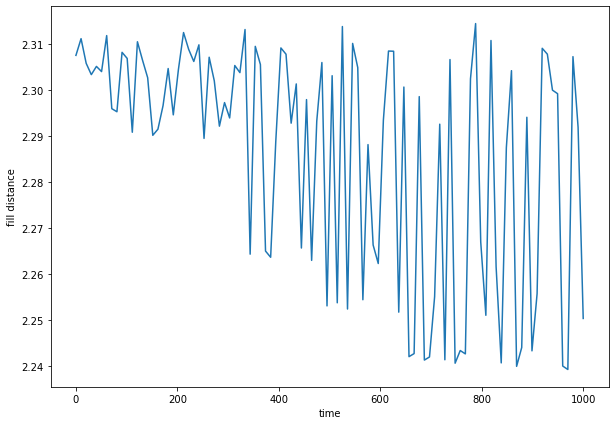

In [235]:
x = np.linspace(0,1000,100)
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Fill Distance')
fill_list = np.zeros(x.size)
for i in range (0,100):
    fill_list[i]=fill_distance_compute(np.reshape(ipts[:,i], (1,3)), finedata[:,fine_ind-window:fine_ind+window].T)
plt.figure(figsize=(10,7))
plt.plot(x, fill_list)
plt.xlabel(r'time')
plt.ylabel(r'fill distance')
plot_name = 'Signum Fill Distance'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [453]:
# ------------------------
# Jacobian Comparison
# ------------------------
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[0, 0] = -1
pjac_mat_exact[0, 1] = 1.
NTT = np.shape(reddata)[1]
for jj in range(10,11):
    
    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    
    pjac_mat_exact[1, 0] = -2*yloc[2]*dirac(yloc[0])
    pjac_mat_exact[1, 2] = -np.sign(yloc[0])
    pjac_mat_exact[2, 0] = np.sign(yloc[1])
    pjac_mat_exact[2, 1] = 2*yloc[0]*dirac(yloc[1])
    
    jacmat, cval = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    print('Estimated Jacobian:')
    print(jacmat,'\n')
    print('Actual Jacobian')
    print(pjac_mat_exact)
    print("Condition number is: %1.2e" % cval)

Estimated Jacobian:
[[-1.00345437e+00  1.00095992e+00 -1.05060912e-03]
 [-7.81136969e-03  5.26304047e-03 -9.98140935e-01]
 [ 1.00688949e+00 -3.68039131e-03 -2.90699031e-04]] 

Actual Jacobian
[[-1.  1.  0.]
 [-0.  0. -1.]
 [ 1.  0.  0.]]
Condition number is: 1.37e+08


In [454]:
# -------------------
# Save dialog
# -------------------
save_jacmat = create_directory('Jacobian')
save_jacmat = create_subdirectory(save_jacmat, 'Signum')
name = 'Signum Estimated Jacobian' + rbf_shape
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(jacmat))
table_write.close()

# name = 'Signum Exact Jacobian'
# plot_name = name_checker(save_jacmat, name, '.txt')
# filepath = save_jacmat + name + '.txt'
# table_write = open(filepath, 'w')
# table_write.write(str(pjac_mat_exact))
# table_write.close()

We can see that our estimated Jacobian is well-behaved in respect to the exact Jacobian

Calculating condition numbers...


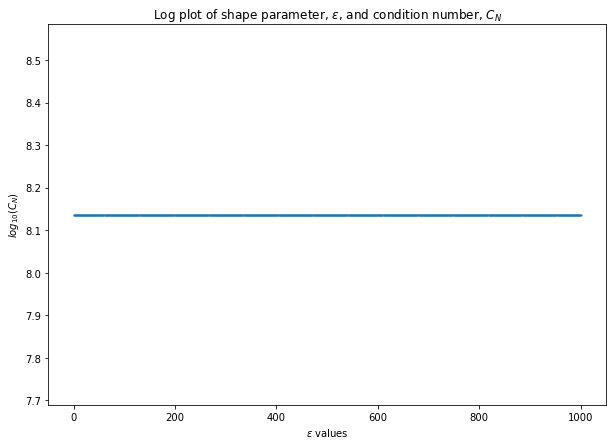

In [455]:
# -------------------------
# Condition Number Plot
# -------------------------
print('Calculating condition numbers...')
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Condition Number Plots')
condnumbers = [rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).condition_number_compute(epval) for epval in epvals]
plt.figure(figsize=(10,7))
plt.scatter(epvals, np.ma.log10(condnumbers), s=1)
plt.xlabel(r'$\epsilon$ values')
plt.ylabel(r'$log_{10}(C_N)$')
plt.title(r'Log plot of shape parameter, $\epsilon$, and condition number, $C_N$')
plot_name = 'Signum ' + rbf_shape
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [456]:
# ---------------------------
# Calculating Lyapunov Exp
# ---------------------------
NTT = np.shape(reddata)[1]
qprior = np.eye(3, dtype=np.float64)
imat = np.eye(3, dtype=np.float64)
rvals = np.ones((3, NTT), dtype=np.float64)
for jj in range(NTT - 1):
    jacmatn, cvaln = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    jacmatp, cvalp = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj + 1, NTT)
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat - time_step / 2 * jacmatp), (imat + time_step / 2 * jacmatn) @ qprior))
    rvals[:, jj] = np.diag(rnext)
lvals = np.sum(np.log(np.abs(rvals)), 1) / stop_time
print('Estimated Lyapunov Exponents: ', lvals)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Estimated Lyapunov Exponents:  [ 1.47271116 -0.00476395 -2.06125173]
Comparison Lyapunov Exponents:  [-0.05543617 -1.77310265 -1.88472336]


In [457]:
# --------------------
# Save dialog
# --------------------
head = ['RBF', 'lambda 1', 'lambda 2', 'lambda 3']
row = [rbf_shape, lvals[0], lvals[1], lvals[2]]
table = tabulate([head, row], headers='firstrow')
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Signum')
table_name = 'RBF Estimated Signum Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
RBF        lambda 1     lambda 2    lambda 3
-------  ----------  -----------  ----------
quintic     1.47271  -0.00476395    -2.06125


# Remarks
Here we can see that the maximal Lyapunov exponent is a little off...However, overall everything looks good

# Rabinovich-Fabrikant Attractor
The Rabinovich-Fabrikant system is given by:
\begin{align}
\dot{y}_{1} = & y_{2}(y_{3} - 1 + y_{1}^2) + by_{1}\\
\dot{y}_{2} = & y_{1}(3y_{3} + 1 - y_{1}^2) + by_{2}\\
\dot{y}_{3} = & -2y_{3}(a + y_{1}y_{2})
\end{align}

The Jacobian  is:
$$
J(t) = \begin{pmatrix}
2y_{2}(t)y_{1}(t) + b & y_{3}(t) - 1 + y_{1}^2(t) & y_{2}(t) \\ 
3y_{3}(t) + 1 - 3y_{1}^2(t) & b & 3y_{1}(t) \\ 
-2y_{2}(t)y_{3}(t) & -2y_{1}(t)y_{3}(t) & -2a
\end{pmatrix}
$$

where a=-0.1 and b=-1

The position of the initial condition can make the attractor unstable when integrating with Runge-Kutta methods. This is explored in **Meador, A Comparison of two 4th-Order Numerical
Ordinary Differential Equation Methods Applied
to the Rabinovich-Fabrikant Equations, Marshall University, 2009.**. The initial condition (0, 1, 0) used for all of the systems prior causes this system to be unstable so an initial condition of (0.1, 0.1, 0.1) is chosen which is given from **Meador 2011**. This attractor's shape changes dramatically depending on its parameters so we will explore two cases

In [101]:
# --------------------------
# Dynamical System Data
# --------------------------
a = -0.1
b = -1
time_step=0.01
init_cond = np.array([0.1, 0.1, 0.1])
system = lambda t, X: fds.Systems(X).rabinovich(-0.1, -1)
solver = fds.Scheme(system, init_cond, start_time, stop_time, time_step)
rawdata, name = solver.runge_kutta()

In [102]:
fine = fds.Scheme(system, init_cond, start_time, stop_time, time_step/10)
finedata, name = fine.runge_kutta()

In [103]:
def rabinovich_lyupanov_solver(yt, a, b, dt):
    NT = np.shape(yt)[1]
    gs_rem_terms = np.ones((3, NT), dtype=np.float64)
    jac_mat = np.zeros((3, 3), dtype=np.float64)
    jac_mat[1, 1] = b
    jac_mat[2, 2] = -2*a
    
    #print(jac_mat)
    
    uprior = np.eye(3, dtype=np.float64)

    for jj in range(NT-1):
        jac_mat[0, 0] = 2*yt[1, jj]*yt[0, jj] + b
        jac_mat[0, 1] = yt[2, jj] - 1 + yt[0, jj]**2
        jac_mat[0, 2] = yt[1, jj]
        jac_mat[1, 0] = 3*yt[2, jj] + 1 - 3*yt[0, jj]**2
        jac_mat[1, 2] = 3*yt[0, jj]
        jac_mat[2, 0] = -2*yt[1, jj]*yt[2, jj]
        jac_mat[2, 1] = -2*yt[0, jj]*yt[2, jj]
        
        #print(jac_mat)

        jupdate = lambda uvec: jac_mat @ uvec
        unext = np.zeros((3, 3), dtype=np.float64)

        for ll in range(3):
            unext[:, ll] = rk4(uprior[:, ll], jupdate, dt)

        uprior, rnext = np.linalg.qr(unext)
        gs_rem_terms[:, jj+1] = np.diag(rnext)
        

    return np.sum(np.log(np.abs(gs_rem_terms)), 1)/(NT*dt)

In [104]:
# # --------------------------
# # Attractor Plots
# # --------------------------
# print('Plotting 3D attractor...')
# save_attractor = create_directory('Plots')
# save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
# fig = plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")
# ax.plot3D(rawdata[0, :], rawdata[1, :], rawdata[2, :])
# ax.set_title(r'Rabinovich-Fabrikant Attractor for $a=-0.1$, $b=-1$')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plot_name = 'RF1'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_3D, plot_name, '.png')
# filepath = save_attractor_3D + plot_name
# plt.savefig(filepath)
# plt.show()

# """2D Plots"""
# print('Plotting 2D projections of attractor...')
# save_attractor_2D = create_subdirectory(save_attractor, 'Attractor Plots', '2D Plots')
# plt.figure(figsize=(5,15))
# plt.suptitle(r'Rabinovich-Fabrikant Attractor for $a=-0.1$, $b=-1$')
# plt.subplot(3,1,1)
# plt.plot(rawdata[0, :], rawdata[1, :])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('XY Plot')

# plt.subplot(3,1,2)
# plt.plot(rawdata[0, :], rawdata[2, :])
# plt.xlabel('x')
# plt.ylabel('z')
# plt.title('XZ Plot')

# plt.subplot(3,1,3)
# plt.plot(rawdata[1, :], rawdata[2, :])
# plt.xlabel('y')
# plt.ylabel('z')
# plt.title('XZ Plot')
# plot_name = 'RF1'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_2D, plot_name, '.png')
# filepath = save_attractor_2D + plot_name
# plt.savefig(filepath)
# plt.show()


In [105]:
# # --------------------------
# # Attractor Plots
# # --------------------------
# print('Plotting 3D attractor...')
# save_attractor = create_directory('Plots')
# save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
# fig = plt.figure(figsize=(10, 7))
# ax = plt.axes(projection="3d")
# ax.plot3D(finedata[0, :], finedata[1, :], finedata[2, :])
# #ax.set_title(r'Rabinovich-Fabrikant Attractor for $a=-0.1$, $b=-1$')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plot_name = 'RF1 Fine'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_3D, plot_name, '.png')
# filepath = save_attractor_3D + plot_name
# plt.savefig(filepath)
# plt.show()

In [106]:
lyu_vals = rabinovich_lyupanov_solver(rawdata, a, b, time_step)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Comparison Lyapunov Exponents:  [ 0.28349808  0.02141714 -1.9066755 ]


In [62]:
# -------------------
# Save Dialog
# -------------------
row = ['RF1005', lyu_vals[0], lyu_vals[1], lyu_vals[2]]
table = tabulate([row])
save_table = create_directory('Tables')
table_name = 'Deici Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write('\n' + table)
table_write.close()
print('Comparison Lyapunov Exponents: \n', table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
Comparison Lyapunov Exponents: 
 ------  --------  ---------  --------
RF1005  0.280711  0.0300034  -1.90982
------  --------  ---------  --------


This is not in agreement with **Meador 2011**. Meador only cites the maximal Lyapunov exponent which they report at 0.071203019400215

In [107]:
# --------------------------
# Data Manipulation
# --------------------------
transient_skp = 400
reddata = rawdata[:, transient_skp:]
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

Plotting epsilons...
Save file as: 


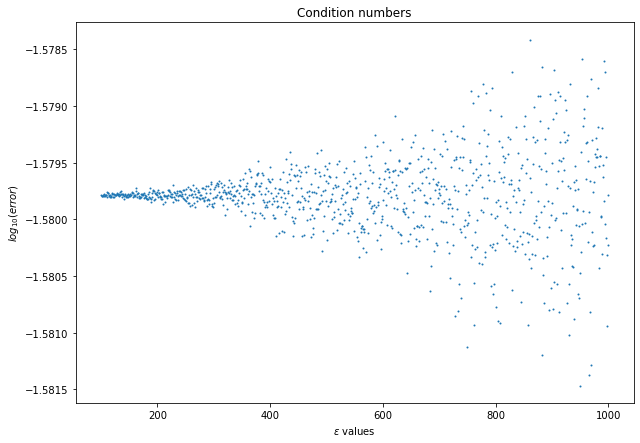

In [108]:
# --------------------------
# Finding Optimal Shape Param
# --------------------------
epvals = np.linspace(0.1, 1000, 1001)
ptindx = 10
fine_ind = 10*ptindx
yloc = reddata[:, ptindx]
nnindices = indices[ptindx]
ipts = reddata[:, nnindices]
interpolator = rbf.RBF_Interpolate(rbf_shape, ipts, time_step)
optimal_shape_parameter = rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).shape_parameter_tuner()

In [65]:
# -----------------------
# Save dialog
# -----------------------
row = [rbf_shape, optimal_shape_parameter]
table = tabulate([row])
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Rabinovich-Fabrikant')
table_name = 'Optimal Epsilon RF1005'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

--------  -----
gaussian  523.9
--------  -----


In [66]:
# -----------------------
# Fill distance
# -----------------------
window = 4
hfill = interpolator.fill_distance_compute(finedata[:,fine_ind-window:fine_ind+window].T)
print(hfill)

0.6724397155746324


In [67]:
# -----------------------
# Save dialog
# -----------------------
row = ['rf1005', hfill]
table = tabulate([row])
save_table = create_directory('Tables')
#save_table = create_subdirectory(save_table, 'Lorenz')
table_name = 'Fill Distance'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
------  -------
rf1005  0.67244
------  -------


A file of this name already exists! Do you want to rewrite it? [y/n]: y


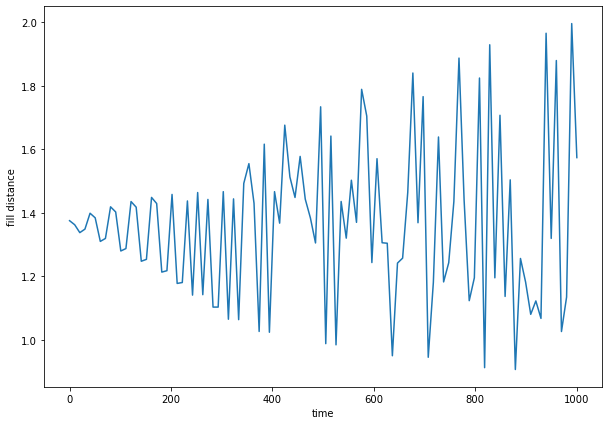

In [68]:
x = np.linspace(0,1000,100)
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Fill Distance')
fill_list = np.zeros(x.size)
for i in range (0,100):
    fill_list[i]=fill_distance_compute(np.reshape(ipts[:,i], (1,3)), finedata[:,fine_ind-window:fine_ind+window].T)
plt.figure(figsize=(10,7))
plt.plot(x, fill_list)
plt.xlabel(r'time')
plt.ylabel(r'fill distance')
plot_name = 'RF1 Fill Distance'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [109]:
# ------------------------
# Jacobian Comparison
# ------------------------
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[1, 1] = b
pjac_mat_exact[2, 2] = -2*a
NTT = np.shape(reddata)[1]
for jj in range(10,11):
    
    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    
    pjac_mat_exact[0, 0] = 2*yloc[1]*yloc[0] + b
    pjac_mat_exact[0, 1] = yloc[2] - 1 + yloc[0]**2
    pjac_mat_exact[0, 2] = yloc[1]
    pjac_mat_exact[1, 0] = 3*yloc[2] + 1 - 3*yloc[0]**2
    pjac_mat_exact[1, 2] = 3*yloc[0]
    pjac_mat_exact[2, 0] = -2*yloc[1]*yloc[2]
    pjac_mat_exact[2, 1] = -2*yloc[0]*yloc[2]
    
    jacmat, cval = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    print('Estimated Jacobian:')
    print(jacmat,'\n')
    print('Actual Jacobian')
    print(pjac_mat_exact)
    print("Condition number is: %1.2e" % cval)

Estimated Jacobian:
[[-1.00972544e+00 -7.76529090e-01  6.68411064e-03]
 [ 1.69282276e+00 -9.98895165e-01 -1.50358219e-02]
 [ 1.43326675e-04 -3.11890089e-04  2.00091465e-01]] 

Actual Jacobian
[[-1.00000464e+00 -7.74222986e-01 -2.43218040e-03]
 [ 1.67732559e+00 -1.00000000e+00  2.85886457e-03]
 [ 1.09825644e-03 -4.30308873e-04  2.00000000e-01]]
Condition number is: 2.14e+20


In [110]:
# -------------------
# Save dialog
# -------------------
save_jacmat = create_directory('Jacobian')
save_jacmat = create_subdirectory(save_jacmat, 'Rabinovich-Fabrikant')
name = 'RF1 trial2 Estimated Jacobian' + rbf_shape
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(jacmat))
table_write.close()

name = 'RF1 trial 2 Exact Jacobian'
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(pjac_mat_exact))
table_write.close()

The Jacobians look somewhat similar with a few magnitude differences

Calculating condition numbers...


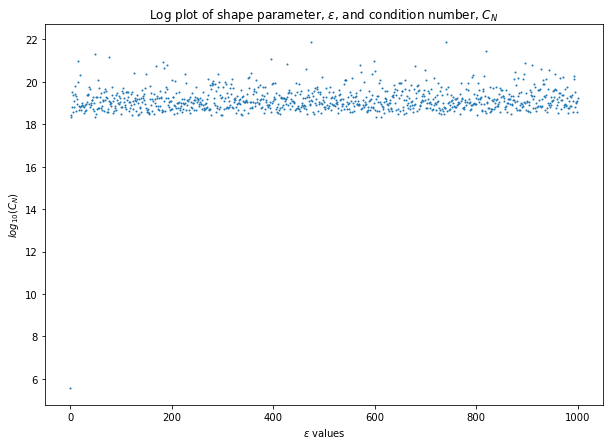

In [71]:
# -------------------------
# Condition Number Plot
# -------------------------
print('Calculating condition numbers...')
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Condition Number Plots')
condnumbers = [rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).condition_number_compute(epval) for epval in epvals]
plt.figure(figsize=(10,7))
plt.scatter(epvals, np.ma.log10(condnumbers), s=1)
plt.xlabel(r'$\epsilon$ values')
plt.ylabel(r'$log_{10}(C_N)$')
plt.title(r'Log plot of shape parameter, $\epsilon$, and condition number, $C_N$')
plot_name = 'RF1005 ' + rbf_shape
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [111]:
# ---------------------------
# Calculating Lyapunov Exp
# ---------------------------
NTT = np.shape(reddata)[1]
qprior = np.eye(3, dtype=np.float64)
imat = np.eye(3, dtype=np.float64)
rvals = np.ones((3, NTT), dtype=np.float64)
for jj in range(NTT - 1):
    jacmatn, cvaln = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    jacmatp, cvalp = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj + 1, NTT)
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat - time_step / 2 * jacmatp), (imat + time_step / 2 * jacmatn) @ qprior))
    rvals[:, jj] = np.diag(rnext)
lvals = np.sum(np.log(np.abs(rvals)), 1) / stop_time
print('Estimated Lyapunov Exponents: ', lvals)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Estimated Lyapunov Exponents:  [ 0.46007997 -0.07181909 -0.64774365]
Comparison Lyapunov Exponents:  [ 0.28349808  0.02141714 -1.9066755 ]


In [73]:
# --------------------
# Save dialog
# --------------------
head = ['RBF', 'lambda 1', 'lambda 2', 'lambda 3']
row = [rbf_shape, lvals[0], lvals[1], lvals[2]]
table = tabulate([head, row], headers='firstrow')
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Rabinovich-Fabrikant')
table_name = 'RBF Estimated RF1005 exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

RBF         lambda 1    lambda 2    lambda 3
--------  ----------  ----------  ----------
gaussian    0.583414   -0.119153    -0.75737


# Remarks
I am not entirely sure what to make of this. From a certain point of view these are "close" perhaps a greater time observing the attractor would cause it to converge more

We turn our attention to Rabinovich-Fabrikant where a = 0.98 and b = 0.1

In [133]:
# --------------------------
# Dynamical System Data
# --------------------------
a = 0.98
b = 0.1
time_step=0.05
init_cond = np.array([0.1, 0.1, 0.1])
system = lambda t, X: fds.Systems(X).rabinovich()
solver = fds.Scheme(system, init_cond, start_time, stop_time, time_step)
rawdata, name = solver.runge_kutta()

In [134]:
fine = fds.Scheme(system, init_cond, start_time, stop_time, time_step/10)
finedata, name = fine.runge_kutta()

Plotting 3D attractor...


Text(0.5, 0, 'z')

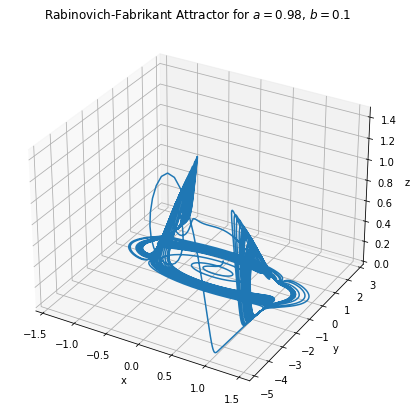

In [142]:
# --------------------------
# Attractor Plots
# --------------------------
print('Plotting 3D attractor...')
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.plot3D(rawdata[0, :], rawdata[1, :], rawdata[2, :])
ax.set_title(r'Rabinovich-Fabrikant Attractor for $a=0.98$, $b=0.1$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plot_name = 'RF2'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_3D, plot_name, '.png')
# filepath = save_attractor_3D + plot_name
# plt.savefig(filepath)
# plt.show()

# """2D Plots"""
# print('Plotting 2D projections of attractor...')
# save_attractor_2D = create_subdirectory(save_attractor, 'Attractor Plots', '2D Plots')
# plt.figure(figsize=(5,15))
# plt.suptitle(r'Rabinovich-Fabrikant Attractor for $a=0.98$, $b=0.1$')
# plt.subplot(3,1,1)
# plt.plot(rawdata[0, :], rawdata[1, :])
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('XY Plot')

# plt.subplot(3,1,2)
# plt.plot(rawdata[0, :], rawdata[2, :])
# plt.xlabel('x')
# plt.ylabel('z')
# plt.title('XZ Plot')

# plt.subplot(3,1,3)
# plt.plot(rawdata[1, :], rawdata[2, :])
# plt.xlabel('y')
# plt.ylabel('z')
# plt.title('XZ Plot')
# plot_name = 'RF2'
# if str(type(plot_name)) != "<class 'str'>":
#     plot_name = str(plot_name)
# plot_name = name_checker(save_attractor_2D, plot_name, '.png')
# filepath = save_attractor_2D + plot_name
# plt.savefig(filepath)
# plt.show()


Plotting 3D attractor...
A file of this name already exists! Do you want to rewrite it? [y/n]: y


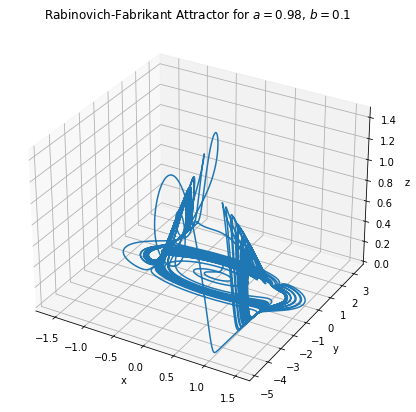

In [246]:
# --------------------------
# Attractor Plots
# --------------------------
print('Plotting 3D attractor...')
save_attractor = create_directory('Plots')
save_attractor_3D = create_subdirectory(save_attractor, 'Attractor Plots', '3D Plots')
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.plot3D(finedata[0, :], finedata[1, :], finedata[2, :])
ax.set_title(r'Rabinovich-Fabrikant Attractor for $a=0.98$, $b=0.1$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plot_name = 'RF2 Fine'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_attractor_3D, plot_name, '.png')
filepath = save_attractor_3D + plot_name
plt.savefig(filepath)
plt.show()

In [121]:
lyu_vals = rabinovich_lyupanov_solver(rawdata, a, b, time_step)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Comparison Lyapunov Exponents:  [-0.05543617 -1.77310265 -1.88472336]


In [81]:
# -------------------
# Save Dialog
# -------------------
row = ['RF2005', lyu_vals[0], lyu_vals[1], lyu_vals[2]]
table = tabulate([row])
save_table = create_directory('Tables')
table_name = 'Deici Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write('\n' + table)
table_write.close()
print('Comparison Lyapunov Exponents: \n', table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
Comparison Lyapunov Exponents: 
 ------  ----------  --------  --------
RF2005  -0.0570143  -1.78344  -1.88097
------  ----------  --------  --------


**Meador 2011** only provides the maximal Lyapunov exponent. It is worth noting however, that this result does not agree with Meador. Meador reports that the attractor for these parameters is chaotic with a maximal Lyapunov exponent of 0.023375301581978. Either there is a flaw in the algorithm we are using to check our values or Meador is incorrect. The latter I think is the less likely scenario. Still, I think continuing in this exercise will be useful and give us some information leading to some intuition about these attractors as we shall soon see

In [137]:
# --------------------------
# Data Manipulation
# --------------------------
transient_skp = 400
reddata = rawdata[:, transient_skp:]
nbrs = NearestNeighbors(n_neighbors=100, algorithm='kd_tree').fit(reddata.T)
distances, indices = nbrs.kneighbors(reddata.T)

Plotting epsilons...
Save file as: 


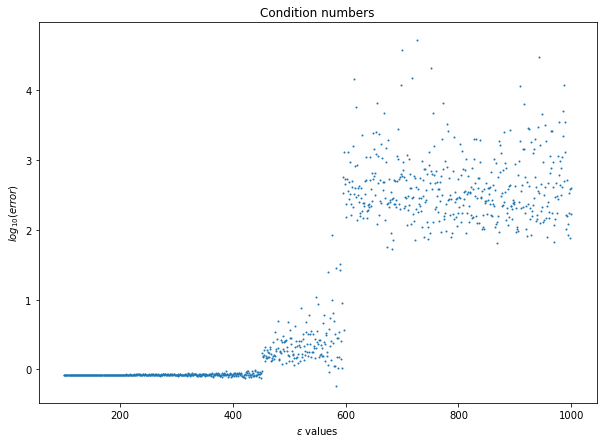

In [138]:
# --------------------------
# Finding Optimal Shape Param
# --------------------------
epvals = np.linspace(0.1, 1000, 1001)
ptindx = 10
fine_ind = 10*ptindx
yloc = reddata[:, ptindx]
nnindices = indices[ptindx]
ipts = reddata[:, nnindices]
interpolator = rbf.RBF_Interpolate(rbf_shape, ipts, time_step)
optimal_shape_parameter = rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).shape_parameter_tuner()

In [96]:
# -----------------------
# Save dialog
# -----------------------
row = [rbf_shape, optimal_shape_parameter]
table = tabulate([row])
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Rabinovich-Fabrikant')
table_name = 'Optimal Epsilon RF2001'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

--------  -----
gaussian  138.7
--------  -----


In [139]:
# -----------------------
# Fill distance
# -----------------------
window = 4
hfill = interpolator.fill_distance_compute(finedata[:,fine_ind-window:fine_ind+window].T)
print(hfill)

0.16138310090614555


In [98]:
# -----------------------
# Save dialog
# -----------------------
row = ['rf2001', hfill]
table = tabulate([row])
save_table = create_directory('Tables')
#save_table = create_subdirectory(save_table, 'Lorenz')
table_name = 'Fill Distance'
plot_name = name_checker(save_table, table_name, '.txt')
filepath = save_table + table_name + '.txt'
table_write = open(filepath, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
------  --------
rf2001  0.125107
------  --------


A file of this name already exists! Do you want to rewrite it? [y/n]: n


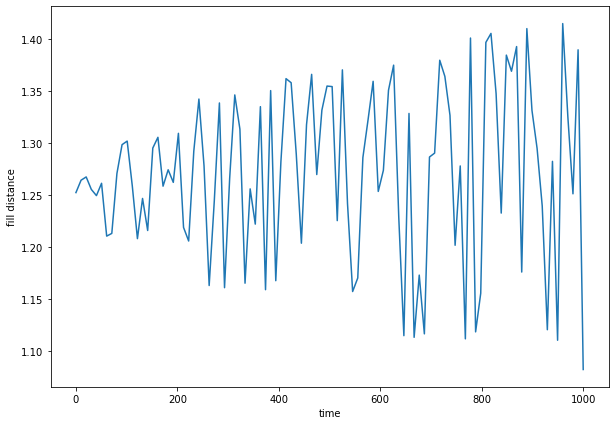

In [140]:
x = np.linspace(0,1000,100)
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Fill Distance')
fill_list = np.zeros(x.size)
for i in range (0,100):
    fill_list[i]=fill_distance_compute(np.reshape(ipts[:,i], (1,3)), finedata[:,fine_ind-window:fine_ind+window].T)
plt.figure(figsize=(10,7))
plt.plot(x, fill_list)
plt.xlabel(r'time')
plt.ylabel(r'fill distance')
plot_name = 'RF2001 Fill Distance'
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [124]:
# ------------------------
# Jacobian Comparison
# ------------------------
pjac_mat_exact = np.zeros((3, 3), dtype=np.float64)
pjac_mat_exact[1, 1] = b
pjac_mat_exact[2, 2] = -2*a
NTT = np.shape(reddata)[1]
for jj in range(10,11):
    
    yloc = reddata[:,jj]
    nnindices = indices[jj]
    ipts = reddata[:,nnindices]
    
    pjac_mat_exact[0, 0] = 2*yloc[1]*yloc[0] + b
    pjac_mat_exact[0, 1] = yloc[2] - 1 + yloc[0]**2
    pjac_mat_exact[0, 2] = yloc[1]
    pjac_mat_exact[1, 0] = 3*yloc[2] + 1 - 3*yloc[0]**2
    pjac_mat_exact[1, 2] = 3*yloc[0]
    pjac_mat_exact[2, 0] = -2*yloc[1]*yloc[2]
    pjac_mat_exact[2, 1] = -2*yloc[0]*yloc[2]
    
    jacmat, cval = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    print('Estimated Jacobian:')
    print(jacmat,'\n')
    print('Actual Jacobian')
    print(pjac_mat_exact)
    print("Condition number is: %1.2e" % cval)

Estimated Jacobian:
[[ 4.32015660e+02 -7.13805115e+03  6.82242916e+05]
 [-6.06902616e+02  1.00448991e+04 -9.60195598e+05]
 [-3.47837304e-02  5.82746371e-01 -5.58510818e+01]] 

Actual Jacobian
[[ 8.89165841e-02 -9.99348167e-01 -2.22526028e-01]
 [ 9.98234351e-01  1.00000000e-01  7.47109185e-02]
 [ 1.40821997e-05 -1.57598654e-06 -1.96000000e+00]]
Condition number is: 6.47e+18


In [89]:
# -------------------
# Save dialog
# -------------------
save_jacmat = create_directory('Jacobian')
save_jacmat = create_subdirectory(save_jacmat, 'Rabinovich-Fabrikant')
name = 'RF2005 Estimated Jacobian' + rbf_shape
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(jacmat))
table_write.close()

name = 'RF2005 Exact Jacobian'
plot_name = name_checker(save_jacmat, name, '.txt')
filepath = save_jacmat + name + '.txt'
table_write = open(filepath, 'w')
table_write.write(str(pjac_mat_exact))
table_write.close()

Here we can see that our scattered interpolation Jacobian is not well-behaved

Calculating condition numbers...
A file of this name already exists! Do you want to rewrite it? [y/n]: n


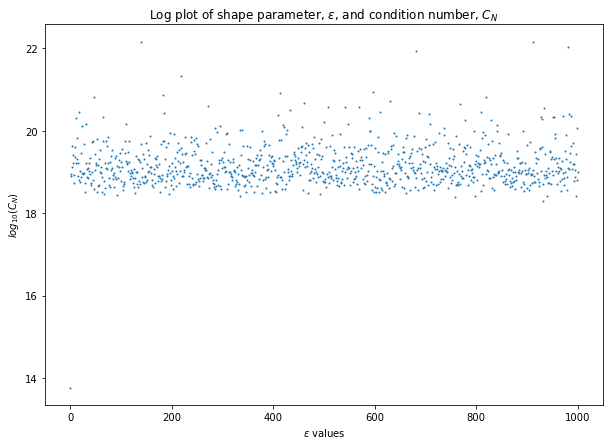

In [90]:
# -------------------------
# Condition Number Plot
# -------------------------
print('Calculating condition numbers...')
save_plot = create_directory('Plots')
save_plot = create_subdirectory(save_plot, 'Condition Number Plots')
condnumbers = [rbf.RBF_Interpolate(rbf_shape, ipts.T, time_step).condition_number_compute(epval) for epval in epvals]
plt.figure(figsize=(10,7))
plt.scatter(epvals, np.ma.log10(condnumbers), s=1)
plt.xlabel(r'$\epsilon$ values')
plt.ylabel(r'$log_{10}(C_N)$')
plt.title(r'Log plot of shape parameter, $\epsilon$, and condition number, $C_N$')
plot_name = 'RF2 ' + rbf_shape
if str(type(plot_name)) != "<class 'str'>":
    plot_name = str(plot_name)
plot_name = name_checker(save_plot, plot_name, '.png')
filepath = save_plot + plot_name
plt.savefig(filepath)
plt.show()

In [125]:
# ---------------------------
# Calculating Lyapunov Exp
# ---------------------------
NTT = np.shape(reddata)[1]
qprior = np.eye(3, dtype=np.float64)
imat = np.eye(3, dtype=np.float64)
rvals = np.ones((3, NTT), dtype=np.float64)
for jj in range(NTT - 1):
    jacmatn, cvaln = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj, NTT)
    jacmatp, cvalp = interpolator.jacobian_maker(reddata, indices, optimal_shape_parameter, jj + 1, NTT)
    qprior, rnext = np.linalg.qr(np.linalg.solve((imat - time_step / 2 * jacmatp), (imat + time_step / 2 * jacmatn) @ qprior))
    rvals[:, jj] = np.diag(rnext)
lvals = np.sum(np.log(np.abs(rvals)), 1) / stop_time
print('Estimated Lyapunov Exponents: ', lvals)
print('Comparison Lyapunov Exponents: ', lyu_vals)

Estimated Lyapunov Exponents:  [ 0.62202953  0.08222562 -0.57467634]
Comparison Lyapunov Exponents:  [-0.05543617 -1.77310265 -1.88472336]


In [482]:
# --------------------
# Save dialog
# --------------------
head = ['RBF', 'lambda 1', 'lambda 2', 'lambda 3']
row = [rbf_shape, lvals[0], lvals[1], lvals[2]]
table = tabulate([head, row], headers='firstrow')
save_table = create_directory('Tables')
save_table = create_subdirectory(save_table, 'Rabinovich-Fabrikant')
table_name = 'RBF Estimated RF2 Lyapunov exponents'
plot_name = name_checker(save_table, table_name, '.txt')
table_name = save_table + table_name + '.txt'
table_write = open(table_name, 'a')
table_write.write(table)
table_write.close()
print(table)

A file of this name already exists! Do you want to rewrite it? [y/n]: y
RBF        lambda 1    lambda 2    lambda 3
-------  ----------  ----------  ----------
quintic     0.58379   0.0579223   -0.816723


# Remarks
It is more interesting here that the RBF scattered data interpolation heavily disagrees with our Deici algorithm we use to compare our scheme. The scattered data interpolation agrees with Meador that the system is chaotic but does not agree with the maximal Lyapunov Exponent calculated by Meador

# Conclusions
I think that comparing these six attractors was a useful exercize and helps to shed some light on why the Jacobian of the Rossler system is so misbehaved. I'd like to draw attention to the fact that the Rossler system appears to be "flat and peaky" as can be seen in its 2D xz and yz plots. The only other system where the Jacobian was very misbehaved was Rabinovich-Fabrikant where a=0.98 and b=0.1. It is worth noting that this "flat and peaky" shape was not observed in the RF attractor when the parameter values were a=-0.1 and b=-1 and the Jacobian for this version of the attractor was far far more behaved but did have some slight disrepancies.

Lorenz, Chua, and Signum did not exhibit this "flat and peaky" shape and their Jacobians were well-behaved. Lorenz and Chua were extremely well behaved as their Lyapunov exponents agreed largely with what was calculated with Deici and agreed with the literature on the two attractors. The Signum attractor's Lyapunov Exponents calculated through scattered data interpolation was more misbehaved but may be acceptable.

Based on what was observed in this experiment, I think that this "flat and peaky" shape causes the Jacobian of the system to become misbehaved. In chapter 6 of Faushauer he says this statement: "Sometimes it is desirable to have an interpolant that exactly reproduces certain types of functions. For example, if the data are constant, or come from a linear function, then it would be nice if our interpolant were also constant or linear, respectively."

This is just a thought, but I want to throw it out there: Maybe the shape of the interpolant (here gaussian) and "flat and peaky" shape exhibited by Rossler and RF are causing the problem. Perhaps a differently shaped interpolant could yield better results. This also may be why the Signum attractor's exponents appeared slightly off. **Li et. al** discuss how this attractor has a discontinuity and you can see this in its plots. Perhaps this spike throws the calculation off a bit. I am not sure if this intuition is correct but it is where my head is at right now.

We see some oddness happening with the RF system. I am not sure that this is worth exploring in this thesis, but I did think this attractor gave interesting information

# Gyorgi-Fields Attractor

In [ ]:

def gyorgyi_lyupanov_solver(yt, a, b, dt):
    NT = np.shape(yt)[1]
    gs_rem_terms = np.ones((3, NT), dtype=np.float64)
    jac_mat = np.zeros((3, 3), dtype=np.float64)
    kGF1 = 4.0e6
    kGF2 = 2.0
    kGF3 = 3000
    kGF4 = 55.2
    kGF5 = 7000
    kGF6 = 0.09
    kGF7 = 0.23
    M = 0.25
    A = 0.1
    H = 0.26
    C = 8.33e-4
    # kf = 3.5e-4#2.16e-3
    alpha = 666.7
    beta = 0.3478
    X0 = 1.93e-6 * M
    Z0 = 8.33e-6 * M
    V0 = 1.39e-3 * M
    Y0 = 7.72e-6 * M
    T0 = 2308.6
    
    y = lambda x,z,v: ((alpha * kGF6 * Z0 * V0 * z * v) / (kGF1 * H * X0 * x + kGF2 * A * H ** 2 + kf)) / Y0
    yx = lambda x,z,v:
    yz = lambda x,z,v:
    yv = lambda x,v,z:
    #print(jac_mat)
    
    uprior = np.eye(3, dtype=np.float64)

    for jj in range(NT-1):
        jac_mat[0, 0] = T0*((kGF2*A*H**2*Y0/X0)*yx(yt[0, jj], yt[1, jj], yt[2, jj])
                            -4*kGF3*X0*yt[0, jj]
                            +0.25*kGF4*A**0.5*H**1.5*X0**-0.5*(C-Z0*yt[1, jj])*yt[0, jj]**-0.5
                            -0.5*kGF5*X0*yt[1, jj] -kf)
        
        jac_mat[0, 1] = T0*((KGH2*A*H**2*Y0/X0)*yx 
                            - 0.5*KGH4*A**0.5*H**1.5*X0**-0.5*Z0*yt[0, jj**0.5 
                            - 0.5*KGH5*X0*yt[0, jj])
                                                                    
        jac_mat[0, 1] = yt[2, jj] - 1 + yt[0, jj]**2
        jac_mat[0, 2] = yt[1, jj]
        jac_mat[1, 0] = 3*yt[2, jj] + 1 - 3*yt[0, jj]**2
        jac_mat[1, 2] = 3*yt[0, jj]
        jac_mat[2, 0] = -2*yt[1, jj]*yt[2, jj]
        jac_mat[2, 1] = -2*yt[0, jj]*yt[2, jj]
        
        #print(jac_mat)

        jupdate = lambda uvec: jac_mat @ uvec
        unext = np.zeros((3, 3), dtype=np.float64)

        for ll in range(3):
            unext[:, ll] = rk4(uprior[:, ll], jupdate, dt)

        uprior, rnext = np.linalg.qr(unext)
        gs_rem_terms[:, jj+1] = np.diag(rnext)
        

    return np.sum(np.log(np.abs(gs_rem_terms)), 1)/(NT*dt)

In [4]:
# --------------------------
# Dynamical System Data
# --------------------------
kf = 3.5e-4
start_time = 0
stop_time = 5
time_step = 0.00001
init_cond = np.array([2, 5, 3.385])
system = lambda t, X: fds.Systems(X).gyorgyi_fields()
solver = fds.Scheme(system, init_cond, start_time, stop_time, time_step)
rawdata, name = solver.adams_moulton4()

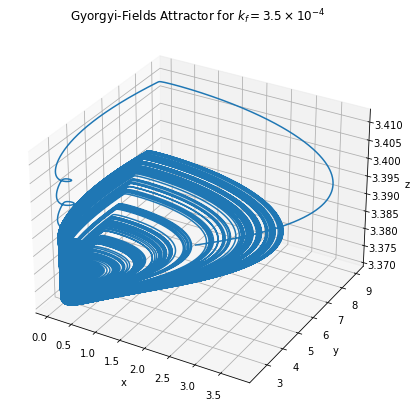

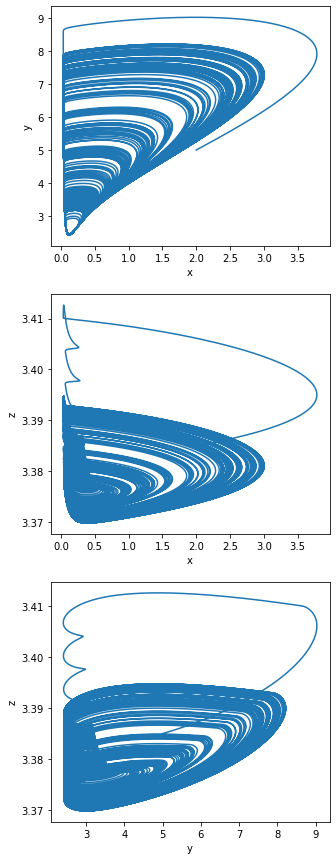

In [6]:
# --------------------------
# Attractor Plots
# --------------------------
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.plot3D(rawdata[0, :], rawdata[1, :], rawdata[2, :])
ax.set_title(r'Gyorgyi-Fields Attractor for $k_{f}=3.5\times 10^{-4}$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

plt.figure(figsize=(5,15))
plt.subplot(3,1,1)
plt.plot(rawdata[0, :], rawdata[1, :])
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(3,1,2)
plt.plot(rawdata[0, :], rawdata[2, :])
plt.xlabel('x')
plt.ylabel('z')

plt.subplot(3,1,3)
plt.plot(rawdata[1, :], rawdata[2, :])
plt.xlabel('y')
plt.ylabel('z')

plt.show()